<a href="https://colab.research.google.com/github/takowasa280/pytorch/blob/main/image_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1.準備

##1.1. データ準備
今回使用するデータは、犬のデータセットを使用して画像分類を試みます。

まずは下記のサイトにアクセスして画像データをダウンロードします。

http://vision.stanford.edu/aditya86/ImageNetDogs/

「Images」のリンクをクリックすれば、画像データのダウンロードが開始されます。

ダウンロードしたデータを解凍すると、120種類の犬種がディレクトリ別に格納されています。

すべてのデータを使うと計算リソースを必要とするので、次の5犬種に絞ってモデルを構築していきます。

・チワワ(Chihuahua)

・シーズー(Shih-Tzu)

・ボルゾイ(borzoi)

・パグ(pug)

・グレートデン(Great-Dane)

ディレクトリ構成は下記のようにしてあります。

In [1]:
"""
├── Images  # 画像データ
│   ├── n02085620-Chihuahua
│   ├── n02086240-Shih-Tzu
│   ├── n02090622-borzoi
│   ├── n02109047-Great_Dane
│   └── n02110958-pug
└── PyTorchによる画像分類の実装.ipynb  # 実装スクリプト
"""

'\n├── Images  # 画像データ\n│   ├── n02085620-Chihuahua\n│   ├── n02086240-Shih-Tzu\n│   ├── n02090622-borzoi\n│   ├── n02109047-Great_Dane\n│   └── n02110958-pug\n└── PyTorchによる画像分類の実装.ipynb  # 実装スクリプト\n'

##1.2.ライブラリ

In [2]:
!free -h 

              total        used        free      shared  buff/cache   available
Mem:            12G        521M          9G        1.1M        2.2G         11G
Swap:            0B          0B          0B


In [3]:
# ライブラリの読み込み
import os
from PIL import Image

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import tensorflow as tf
tf.test.gpu_device_name()

''

In [5]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



##1.3. 前処理
Datasetにデータを渡す準備として、前処理をしていきます。

まずは、用意したデータセットを学習データと検証データに分割します。

格納されているデータ数は各犬種ごとに異なるので、それぞれ学習データを80%、検証データを20%にします。

そして、学習データ、検証データそれぞれのファイルパスを格納したリストを用意します。

In [6]:
image_dir = "drive/MyDrive/Colab Notebooks/Images/"

In [7]:
def make_filepath_list():
    """
    学習データ、検証データそれぞれのファイルへのパスを格納したリストを返す
    
    Returns
    -------
    train_file_list: list
        学習データファイルへのパスを格納したリスト
    valid_file_list: list
        検証データファイルへのパスを格納したリスト
    """
    train_file_list = []
    valid_file_list = []

    for top_dir in os.listdir(image_dir):
        file_dir = os.path.join(image_dir, top_dir)
        file_list = os.listdir(file_dir)

        # 各犬種ごとに8割を学習データ、2割を検証データとする
        num_data = len(file_list)
        num_split = int(num_data * 0.8)

        train_file_list += [os.path.join(image_dir, top_dir, file).replace('\\', '/') for file in file_list[:num_split]]
        valid_file_list += [os.path.join(image_dir, top_dir, file).replace('\\', '/') for file in file_list[num_split:]]
    
    return train_file_list, valid_file_list

# 画像データへのファイルパスを格納したリストを取得する
train_file_list, valid_file_list = make_filepath_list()

print('学習データ数 : ', len(train_file_list))
# 先頭3件だけ表示
print(train_file_list[:3])

print('検証データ数 : ', len(valid_file_list))
# 先頭3件だけ表示
print(valid_file_list[:3])

学習データ数 :  696
['drive/MyDrive/Colab Notebooks/Images/n02090622-borzoi/n02090622_2518.jpg', 'drive/MyDrive/Colab Notebooks/Images/n02090622-borzoi/n02090622_10607.jpg', 'drive/MyDrive/Colab Notebooks/Images/n02090622-borzoi/n02090622_10619.jpg']
検証データ数 :  177
['drive/MyDrive/Colab Notebooks/Images/n02090622-borzoi/n02090622_8509.jpg', 'drive/MyDrive/Colab Notebooks/Images/n02090622-borzoi/n02090622_8221.jpg', 'drive/MyDrive/Colab Notebooks/Images/n02090622-borzoi/n02090622_7905.jpg']


次に画像データに対する前処理(resizeなど)の処理を記述したクラスを作成します。

このクラスに画像データを通せば、指定した前処理を施したデータがえられます。

{train: ～, valid: ～}としている理由は、学習時と推論時で実施する前処理を変えるためです。

学習時にはモデルの性能を高めるために、データオーグメンテーション用の前処理を加えていますが、推論時にはデータオーグメンテーションする必要がないため、画像のサイズを整えるなどの処理だけにとどめています。

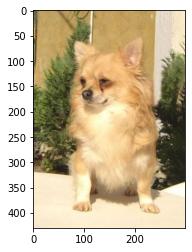

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


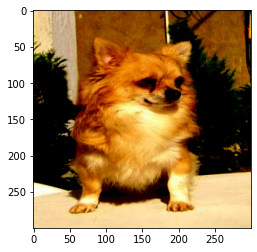

In [8]:
class ImageTransform(object):
    """
    入力画像の前処理クラス
    画像のサイズをリサイズする
    
    Attributes
    ----------
    resize: int
        リサイズ先の画像の大きさ
    mean: (R, G, B)
        各色チャンネルの平均値
    std: (R, G, B)
        各色チャンネルの標準偏差
    """
    def __init__(self, resize, mean, std):
        self.data_trasnform = {
            'train': transforms.Compose([
                # データオーグメンテーション
                transforms.RandomHorizontalFlip(),
                # 画像をresize×resizeの大きさに統一する
                transforms.Resize((resize, resize)),
                # Tensor型に変換する
                transforms.ToTensor(),
                # 色情報の標準化をする
                transforms.Normalize(mean, std)
            ]),
            'valid': transforms.Compose([
                # 画像をresize×resizeの大きさに統一する
                transforms.Resize((resize, resize)),
                # Tensor型に変換する
                transforms.ToTensor(),
                # 色情報の標準化をする
                transforms.Normalize(mean, std)
            ])
        }
    
    def __call__(self, img, phase='train'):
        return self.data_trasnform[phase](img)

# 動作確認
img = Image.open(image_dir+'n02085620-Chihuahua/n02085620_199.jpg')

# リサイズ先の画像サイズ
resize = 300

# 今回は簡易的に(0.5, 0.5, 0.5)で標準化
mean = (0.5, 0.5, 0.5)
std = (0.5, 0.5, 0.5)

transform = ImageTransform(resize, mean, std)
img_transformed = transform(img, 'train')

plt.imshow(img)
plt.show()

plt.imshow(img_transformed.numpy().transpose((1, 2, 0)))
plt.show()

実際にImageTransformクラスを実行してみると、画像がリサイズされ色も標準化されていることがわかります。

加えて、phaseパラメータをtrainに設定して何回か実行すると、画像が左右反転したデータも出力されることがわかります。

##1.4. Datasetの作成
PyTorchのDatasetクラスを継承させたクラスを作ります。

処理を記述する箇所は「__len__」「__getitem__」の二つです。

「__len__」にはDatasetに含まれるデータ数を返す処理を記述します。

「__getitem__」にはindex番号を引数にとり、学習データとラベルデータを返す処理を記述します。

In [9]:
class DogDataset(data.Dataset):
    """
    犬種のDataseクラス。
    PyTorchのDatasetクラスを継承させる。
    
    Attrbutes
    ---------
    file_list: list
        画像のファイルパスを格納したリスト
    classes: list
        犬種のラベル名
    transform: object
        前処理クラスのインスタンス
    phase: 'train' or 'valid'
        学習か検証化を設定
    """
    def __init__(self, file_list, classes, transform=None, phase='train'):
        self.file_list = file_list
        self.transform = transform
        self.classes = classes
        self.phase = phase
    
    def __len__(self):
        """
        画像の枚数を返す
        """
        return len(self.file_list)
    
    def __getitem__(self, index):
        """
        前処理した画像データのTensor形式のデータとラベルを取得
        """
        # 指定したindexの画像を読み込む
        img_path = self.file_list[index]
        img = Image.open(img_path)
        
        # 画像の前処理を実施
        img_transformed = self.transform(img, self.phase)
        
        # 画像ラベルをファイル名から抜き出す
        label = self.file_list[index].split('/')[4][10:]
        #print(self.file_list[index])
        #print(label)
        
        # ラベル名を数値に変換
        label = self.classes.index(label)
        
        return img_transformed, label


# 動作確認
# クラス名
dog_classes = [
    'Chihuahua',  'Shih-Tzu',
    'borzoi', 'Great_Dane', 'pug'
]

# リサイズ先の画像サイズ
resize = 300

# 今回は簡易的に(0.5, 0.5, 0.5)で標準化
mean = (0.5, 0.5, 0.5)
std = (0.5, 0.5, 0.5)

# Datasetの作成
train_dataset = DogDataset(
    file_list=train_file_list, classes=dog_classes,
    transform=ImageTransform(resize, mean, std),
    phase='train'
)

valid_dataset = DogDataset(
    file_list=valid_file_list, classes=dog_classes,
    transform=ImageTransform(resize, mean, std),
    phase='valid'
)

index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

torch.Size([3, 300, 300])
2


##1.5. DataLoaderの作成
バッチ処理を適用するためにDataLoaderを作成して、データセットをバッチ単位で取り出せるようにします。

のちの学習のために、学習用のDataLoaderと検証用のDataLoaderを辞書にまとめています。

In [10]:
# バッチサイズの指定
batch_size = 64

# DataLoaderを作成
train_dataloader = data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

valid_dataloader = data.DataLoader(
    valid_dataset, batch_size=32, shuffle=False)

# 辞書にまとめる
dataloaders_dict = {
    'train': train_dataloader, 
    'valid': valid_dataloader
}

# 動作確認
# イテレータに変換
batch_iterator = iter(dataloaders_dict['train'])

# 1番目の要素を取り出す
inputs, labels = next(batch_iterator)

print(inputs.size())
print(labels)

torch.Size([64, 3, 300, 300])
tensor([0, 0, 2, 3, 0, 4, 3, 4, 2, 1, 1, 2, 4, 4, 1, 4, 1, 3, 1, 1, 3, 1, 4, 4,
        3, 4, 4, 2, 3, 2, 0, 2, 3, 0, 2, 1, 1, 3, 2, 1, 4, 3, 2, 3, 1, 4, 2, 4,
        0, 2, 0, 3, 2, 0, 0, 3, 3, 2, 1, 4, 0, 3, 3, 1])


# 2.ネットワークの作成

##2.1. ネットワークの定義
ネットワークを定義するために、nn.Moduleを継承したクラスを作成します。

「__init__」の中に親クラスのコンストラクタの呼び出しと使用する層を記述して、「forward」の中に順伝播処理を記述していきます。

In [11]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(in_features=128 * 75 * 75, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=5)
    
    def forward(self, x):
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = self.pool1(x)
        
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = self.pool2(x)

        x = x.view(-1, 128 * 75 * 75)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.softmax(x, dim=1)
        
        return x

net = Net()
print(net)

Net(
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=720000, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=5, bias=True)
)


##2.2. 損失関数の定義
損失関数を定義します。

今回はクロスエントロピー誤差を使用します。

In [12]:
criterion = nn.CrossEntropyLoss()

##2.3. 最適化手法の定義
最適化手法を定義します。

最適化していくパラメータとハイパーパラメータを指定していきます。

最適化していくパラメータはnet.parameters()で渡します。

In [13]:
optimizer = optim.SGD(net.parameters(), lr=0.01)

#3.学習と予測

##3.1. 学習の実行
PyTorchでは学習時推論時でネットワークのモードを分ける必要があります。

「net.train()」「net.eval()」でそれぞれのモードを分ける処理を書いています。

In [14]:
dataloaders_dict

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f24192fe190>,
 'valid': <torch.utils.data.dataloader.DataLoader at 0x7f24192fe1d0>}

In [ ]:
# エポック数
num_epochs = 30

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    print('-------------')
    
    for phase in ['train', 'valid']:
        
        if phase == 'train':
            # モデルを訓練モードに設定
            net.train()
        else:
            # モデルを推論モードに設定
            net.eval()
        
        # 損失和
        epoch_loss = 0.0
        # 正解数
        epoch_corrects = 0
        
        # DataLoaderからデータをバッチごとに取り出す
        for inputs, labels in dataloaders_dict[phase]:
            
            # optimizerの初期化
            optimizer.zero_grad()
            
            # 学習時のみ勾配を計算させる設定にする
            with torch.set_grad_enabled(phase == 'train'):
                outputs = net(inputs)
                
                # 損失を計算
                loss = criterion(outputs, labels)
                
                # ラベルを予測
                _, preds = torch.max(outputs, 1)
                
                # 訓練時はバックプロパゲーション
                if phase == 'train':
                    # 逆伝搬の計算
                    loss.backward()
                    # パラメータの更新
                    optimizer.step()
                
                # イテレーション結果の計算
                # lossの合計を更新
                # PyTorchの仕様上各バッチ内での平均のlossが計算される。
                # データ数を掛けることで平均から合計に変換をしている。
                # 損失和は「全データの損失/データ数」で計算されるため、
                # 平均のままだと損失和を求めることができないため。
                epoch_loss += loss.item() * inputs.size(0)
                
                # 正解数の合計を更新
                epoch_corrects += torch.sum(preds == labels.data)

        # epochごとのlossと正解率を表示
        epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
        epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

Epoch 1/30
-------------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train Loss: 1.6089 Acc: 0.2256
valid Loss: 1.6080 Acc: 0.2429
Epoch 2/30
-------------
train Loss: 1.6072 Acc: 0.2457
valid Loss: 1.6065 Acc: 0.2429
Epoch 3/30
-------------


##3.2. 予測の実行
あとは、学習したモデルで推論してやれば予測結果を取得できます。

In [ ]:
# 予測用のダミーデータ
x = torch.randn([1, 3, 300, 300])
preds = net(x)